# Kaggle: Predict Future Sales

Required packages:
numpy, matplotlib, pandas, seaborn, XGBoost, scikit-learn, googlemaps (optional).

In [1]:
# We set jupyter notebook interactivity to all for easier output display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
%run utils.py

The following modules are imported by utils.py:

``` python
import os
from time import sleep
from math import sqrt
from gc import collect
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
```

Constants defined in `utils.py`:

``` python
TARGET = "item_cnt_month"

# A series used for mapping from date_block_num to datetime (first day of each month)
DS = pd.Series(pd.date_range(start = '2013-01-01',end='2015-11-01', freq = 'MS'))
```

along with some functions:

- `load(path)` to load data (in csv/pickle/json format).
- `dump(obj, path)` to dump data (in csv/pickle/json format). (no index when save as csv)
- `prepare_submission(prediction, filename)` to prepare file for submission. This function will clip `prediction`, and by default save to folder `../submissions` if only a file name is given. Default file format is `.csv.gz`.
- `score(prediction, y)` gives the clipped rmse score, i.e. `RMSE(clip(prediction, 0, 20), clip(y, 0, 20))`.

In [3]:
import re
from itertools import product, repeat

Load all data files.

In [4]:
items = load('../data/items.csv')
shops = load('../data/shops.csv')
cates = load('../data/item_categories.csv')
sales = load('../data/sales_train.csv.gz')
test = load('../data/test.csv.gz').drop(columns='ID')

In [5]:
sales.date = pd.to_datetime(sales.date, format='%d.%m.%Y')

## EDA

### 1. Price and sales outliers (from [Denis Larionov](https://www.kaggle.com/dlarionov/feature-engineering-xgboost))

We plot all `price` and `item_cnt_day` in sales record to identify outliers.

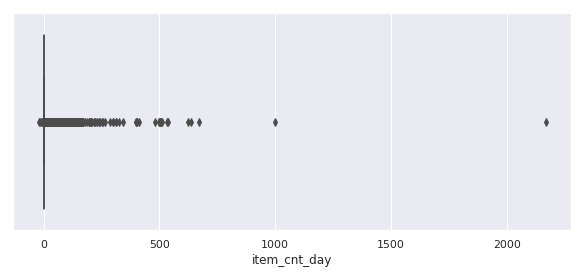

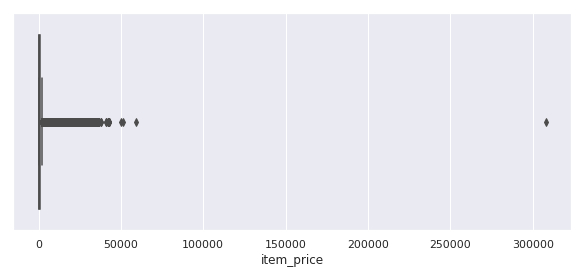

In [6]:
plt.figure(figsize=(10,4));
sns.boxplot(sales.item_cnt_day);
plt.figure(figsize=(10,4));
sns.boxplot(sales.item_price);

In [7]:
# Let's find out what costs 300000+
sales[sales.item_price == sales.item_price.max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [8]:
# This is the only sale of 6066
sales[sales.item_id==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


In [9]:
# This is infact Radmin 3 with 522 licenses
items[items.item_id==6066]
# and is not in our test set
assert 6066 not in test.item_id.unique()

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [10]:
# Remove outliers
sales = sales[(sales.item_cnt_day<2000) & (sales.item_price<300000)]

### 2. One record has negative price ([Denis Larionov](https://www.kaggle.com/dlarionov/feature-engineering-xgboost))

In [11]:
sales[sales.item_price <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [12]:
# Let's find out what is the price near this sale.
# It seems like there was a price drop near 2013-05-15.
# Thus we can replace this price by the average.
sales.loc[(sales.shop_id==32) 
          &(sales.item_id==2973)
          &(sales.date_block_num.isin([3,4,5])),:].sort_values(by='date')
sales.loc[sales.item_price<0, 'item_price'] = (1249+2499)/2

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484684,2013-05-06,4,32,2973,2499.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0
484682,2013-05-23,4,32,2973,1249.0,1.0
555026,2013-06-05,5,32,2973,1249.5,1.0


### 3. Special Shops 9 and 20

Shop 9 and 20 (online/inventory etc) only have data in one month each year, and are not in test set.

In [13]:
# Google translation:
#    shop_id 9 : outbound trades
#    shop_id 20: Moscow "Sale"
special_shops = [9, 20]
shops[shops.shop_id.isin(special_shops)]

,shop_name,shop_id
9,Выездная Торговля,9
20,"Москва ""Распродажа""",20


In [14]:
# These shops only sales (have records) in few months (3 Septembers and 1 March)
sales.loc[sales.shop_id.isin(special_shops)]['date_block_num'].unique()

# And they are not in our test set
assert 9 not in test.shop_id.unique()
assert 20 not in test.shop_id.unique()

array([ 9, 21, 27, 33])

In [15]:
# Remove them from our data.
sales = sales[~sales.shop_id.isin(special_shops)]

### 4. Shop 10 and 11, 0 and 57, 1 and 58 are the same shops. ([DennisE](https://www.kaggle.com/dennise/coursera-competition-getting-started-eda) and [Denis Larionov](https://www.kaggle.com/dlarionov/feature-engineering-xgboost))

Below shows that the saling data are not overlapped for these shops.

In [16]:
# shop 10 and shop 11
shops[shops.shop_id.isin([10, 11])]
print("Shop 11 has sales in", sales[sales.shop_id==11].date_block_num.unique())
print("Shop 10 has sales in", sales[(sales.shop_id==10)].date_block_num.unique())

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


Shop 11 has sales in [25]
Shop 10 has sales in [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30 31 32 33]


In [17]:
# shop 0 and shop 57
shops[shops.shop_id.isin([0,57])]
sales[sales.shop_id.isin([0,57])].groupby('shop_id').agg({'date':['min', 'max']})

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57


date           
               min        max
shop_id                      
0       2013-01-03 2013-02-28
57      2013-03-01 2015-10-31

In [18]:
# shop 1 and 58
shops[shops.shop_id.isin([1, 58])]
sales[sales.shop_id.isin([1,58])].groupby('shop_id').agg({'date':['min', 'max']})

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


date           
               min        max
shop_id                      
1       2013-01-03 2013-02-28
58      2013-03-01 2015-10-31

In [19]:
# So we combine similar shops.
sales = (sales.replace({'shop_id':{0:57, 1:58, 11:10}}))
# Note we only change shops that are not in test set.
assert all(~test.shop_id.isin([0,1,11]))

In [20]:
dump(sales, '../post/sales.csv')

## Feature Engineering

### 1. Prepare data

Test data contains items that are not in `sales_train.csv`. Some of them were released in October/November 2015 (ADELE 25) and some were released much earlier but never sold before (a lot of figures). For this reason, we need to construct our data carefully.

In [21]:
# Get items that are in test set but not in train set
items_test_not_train = set(test.item_id.unique()) - set(sales.reset_index().item_id.unique())

# Five example items that are in test but not in train
items[items.item_id.isin(items_test_not_train)].sample(5)

,item_name,item_id,item_category_id
6733,"Star Wars: Battlefront [Xbox One, русская версия]",6733,24
19210,СУПЕРМЕН 2,19210,40
14647,МИССИЯ НЕВЫПОЛНИМА ПЛЕМЯ ИЗГОЕВ,14647,40
20461,"Фигурка Diablo Diablo POP Games 3.75""",20461,72
15033,"Метод.материалы ""1С:Бухгалтерия государственно...",15033,49


In [22]:
# In order to train a healthy model, we pad zeros at necessary places to mimic test set.
# This data generation scheme is basically from week 3 encoding assignment.
data = []
for i in range(34):
    s = sales[sales.date_block_num==i]
    vsh = s.shop_id.unique()
    vit = s.item_id.unique()
    data.append(np.array(list(product(vsh, vit, [i]))))
data = pd.DataFrame(np.vstack(data), columns=['shop_id', 'item_id', 'date_block_num'])

In [23]:
data = (data.merge(sales.groupby(['shop_id', 'item_id', 'date_block_num'],
                               as_index=False)['item_cnt_day'].sum(),
                 how='left')
        .rename(columns={'item_cnt_day': TARGET})
       )

In [24]:
data.shape

(10913804, 4)

### 1. Shop name -> geocode

In [25]:
# Need google api key to run this cell
# import googlemaps
# gmap = googlemaps.Client("*******Google API Key********")

# lat, lng = [], []
# for shop in shops.shop_name:
#     try:
#         gcode = gmap.geocode(shop)[0]['geometry']['location']
#     except IndexError:
#         gcode = {'lat':np.nan, 'lng':np.nan}
#     lat.append(gcode['lat'])
#     lng.append(gcode['lng'])

# shops = shops.assign(lat=np.array(lat, dtype='float32'),
#                      lng=np.array(lng, dtype='float32'))

In [26]:
# dump(shops, '../post/shops.csv')

In [27]:
shops = load('../post/shops.csv')

In [28]:
shops.sample(5)

,shop_name,shop_id,lat,lng
15,"Калуга ТРЦ ""XXI век""",15,54.516083,36.246662
45,"Самара ТЦ ""ПаркХаус""",45,53.233420,50.200714
17,"Красноярск ТЦ ""Взлетка Плаза""",17,56.034466,92.907860
32,"Москва ТЦ ""Серебряный Дом""",32,55.782090,37.704180
11,Жуковский ул. Чкалова 39м²,11,55.597580,38.124504


### 2. Parsing category names

In [29]:
cates = load('../data/item_categories.csv')

In [30]:
# Category names are in the form: cate1 - cate2 (cate3). 
# We use regular expression to parse it.
re.VERBOSE=True
words = r'[\w/]+(?:\ [\w/]+)*'
pattern = re.compile(r"""^(?P<cate1>{words})              # First phrase
                         (?:\ -\ (?P<cate2>{words}))?     # Second phrase, after '-'
                         (?:\ [(](?P<cate3>{words})[)])?  # Third phrase, inside parenthesis
                         """.format(words=words), re.X)

subcats = cates.item_category_name.str.extract(pattern)
cates = pd.concat([cates, subcats], axis=1)

In [31]:
# These hand typed translation is from calling goolgetrans and is saved to avoid
# repetitive translation. This translation has nothing to do with model accuracy,
# but can help understanding the data.
d1 = dict(zip(cates.cate1.unique(), 
              ['PC', 'Accessories', 'Tickets', 'Delivery of goods',
               'Game consoles', 'Games', 'Android games', 'MAC Games', 'PC games',
               'Payment cards', 'Movie', 'Books', 'Music', 'Presents', 'Programs',
               'Service', 'Clean media', 'Batteries']))
          
d2 = dict(zip(cates.cate2.unique(), 
              ['Headsets / Headphones', 'PS2', 'PS3', 'PS4', 'PSP',
               'Playstation Vita', 'XBOX 360', 'XBOX ONE', np.nan, 'Other',
               'Game accessories', 'Numeral', 'Additional editions',
               'Collectible Editions', 'Standard Editions', 'Live', 'PSN',
               'Windows', 'Blu', 'DVD', "Collector's", 'Artbooks', 'Audiobooks',
               'Audiobooks 1C', 'Business literature', 'Comics',
               'Computer literature', 'Methodical materials 1C', 'Postcards',
               'Cognitive literature', 'Guides', 'Fiction',
               'Local Production CD', 'CD branded production', 'MP3', 'Vinyl',
               'Music video', 'Gift Edition', 'Attributes', 'Gadgets',
               'Stuffed Toys', 'Board games', 'Development', 'Certificates',
               'Souvenirs', 'Bags', 'Figures', '1C', 'MAC', 'For home and office',
               'Educational', 'Tickets']))
          
d3 = dict(zip(cates.cate3.unique(),
              [np.nan, 'Numeral', 'compact', 'in the sample', 'spire', 'piece']))

In [32]:
# Now add parsed and translated category name into our data
for col, d in zip(['cate1', 'cate2', 'cate3'], [d1, d2, d3]):
    cates[col] = cates[col].map(d).fillna('other')

dump(cates, '../post/cates.csv')
cates.sample(5)

,item_category_name,item_category_id,cate1,cate2,cate3
35,Карты оплаты - PSN,35,Payment cards,PSN,other
59,Музыка - Музыкальное видео,59,Music,Music video,other
23,Игры - XBOX 360,23,Games,XBOX 360,other
61,Подарки - Атрибутика,61,Presents,Attributes,other
10,Игровые консоли - PS2,10,Game consoles,PS2,other


### 3. Item average price

In [33]:
# Get item average price
items = items.merge(sales.groupby('item_id', as_index=False)['item_price'].mean(), on=['item_id'], how='left')

In [34]:
# Get category average price
cateavgprice = items.groupby('item_category_id')['item_price'].mean()

# Use category average price to fill na values
items.loc[items.item_price.isna(), 'item_price'] = (items.loc[items.item_price.isna(), 'item_category_id']
                                                    .map(cateavgprice)
                                                   )

In [35]:
# Merge items and cates
items = items.merge(cates.iloc[:,1:], on='item_category_id', how='left')

### 4. Put everything together

In [36]:
# Merge train and test

test['date_block_num'] = 34

data = pd.concat([data, test], ignore_index=True, sort=False, 
                 keys=['shop_id', 'item_id', 'date_block_num'])

In [37]:
# Merge data with shops and items data
data = (data.merge(shops.iloc[:,1:], on=['shop_id'], how='left')
        .merge(items.iloc[:,1:], on=['item_id'], how='left')
       )

In [38]:
# Shrink memory usage
for c in data.select_dtypes(['float64']):
    data[c] = data[c].fillna(0).astype('float32')

for c in data.select_dtypes(['int64']):
    data[c] = data[c].astype('int16')

### 5. Lag target features

In [39]:
# This function is from Denis Larionov's kernel
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [40]:
# Lag target feature by 1, 2 ,3, 4, 5, 6 and 12 months
data = lag_feature(data, [1, 2, 3, 4, 5, 6, 12], TARGET)

In [41]:
# Convert all lag features to `float32`
for c in data.columns:
    if '_lag_' in c:
        data[c] = data[c].fillna(0).astype('float32')

### 6. Some other features.

1. `price_change_from_max`: the difference between the most recent price in last month and the greatest price per item.
2. `price_change_from_last_month`: the difference between the most recent price in last month and the most recent price in the month before.
3. `days_after_first_sale`: number of days after the first sale per shop-item.
4. `days_from_last_sale`: number of days after the most recent sale per item.
5. `month`, `days`: month in a year and number of days in this month.

In [42]:
sorted_sales = sales.sort_values(by='date')

In [43]:
# For each month (first day of each month), find the time and price of the latest previous sale.
last_sale = []
for i in range(1, 35):
    temp = (sorted_sales[sorted_sales.date_block_num<i]
            .groupby(['shop_id', 'item_id'], as_index=False)
            .agg({'date':'max', 'item_price':'last'})
            .rename(columns={'date':'last_sale_date',
                             'item_price':'last_price'})
           )
    temp['date_block_num'] = i
    last_sale.append(temp)

last_sale = pd.concat(last_sale, ignore_index=True)



# Also find the max price and first sale date.
max_and_first_sale = (sales.groupby(['item_id'])
                      .agg({'item_price':'max',
                            'date':'min'})
                      )

In [44]:
# Generate useful data
last_sale['days_from_last_sale'] = (last_sale.date_block_num.map(DS)
                                    - last_sale.last_sale_date)
last_sale['price_change_from_max'] = last_sale.last_price - last_sale.item_id.map(max_and_first_sale['item_price'])
last_sale = lag_feature(last_sale, [1], 'last_price')
last_sale['price_change_from_last_month'] = last_sale.last_price - last_sale.last_price_lag_1

last_sale['days_after_first_sale'] = (last_sale.date_block_num.map(DS) 
                                      - last_sale.item_id.map(max_and_first_sale['date']))

In [45]:
# Merge them to main dataframe and change datatype
last_sale.drop(columns=['last_sale_date', 'last_price_lag_1'], inplace=True)

data = data.merge(last_sale, how='left')

data.loc[data.last_price.isna(), 'last_price'] = data.loc[data.last_price.isna(), 'item_price']
data['last_price'] = data['last_price'].astype('float32')

data['days_from_last_sale'] = data.days_from_last_sale.fillna(pd.Timedelta('9999D')).dt.days.astype('int16')
data['days_after_first_sale'] = data.days_after_first_sale.fillna(pd.Timedelta('9999D')).dt.days.astype('int16')

data['price_change_from_max'] = data.price_change_from_max.fillna(0).astype('float32')
data['price_change_from_last_month'] = data.price_change_from_last_month.fillna(0).astype('float32')

In [46]:
# Days and month feature
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
data['month'] = (data['date_block_num'] % 12).astype('int16')
data['days'] = data['month'].map(days).astype('int16')

## Mean Encoding (including interaction)

In [47]:
# Average target value is used to fill nan encoding, as suggested in the assignment.
AVG = data[TARGET].mean()

def kfold_mean_encoding(all_data, cols, target=TARGET):
    """
    Mean encoding with KFold cv scheme. Can encode multiple categorical columns (interaction).
    When `cols` is a list of columns, then encoding are based on the combination of all these columns.
    """
    data = all_data.copy()
    from sklearn.model_selection import KFold
    tr_id = np.nonzero(data['date_block_num']<33)[0]
    colname = cols if isinstance(cols, str) else '-'.join(cols)
    colname += '-enc'
    data[colname] = np.nan
    kf = KFold(5, False)
    for other, this in kf.split(tr_id):
        code = data.iloc[tr_id[other]].groupby(cols)[target].mean()
        data.loc[data.index[tr_id[this]], colname] = \
            data.iloc[tr_id[this]].set_index(cols).index.map(code).fillna(AVG)
    return data


def encode_valid_test(all_data, cols, target=TARGET):
    """For validation and test set, mean encoding is from train data."""
    data = all_data.copy()
    tr_id = np.nonzero(data['date_block_num']<33)[0]
    vt_id = np.nonzero(data['date_block_num']>=33)[0]
    colname = cols if isinstance(cols, str) else '-'.join(cols)
    colname += '-enc'
    code = data.iloc[tr_id].groupby(cols)[target].mean()
    data.loc[data.index[vt_id], colname] = \
        data.iloc[vt_id].set_index(cols).index.map(code).fillna(AVG)
    return data


def encode(data, cols, target=TARGET):
    """Mean encoding whole data. KFold used for train set. Train set used for validation and test set"""
    return (data.pipe(kfold_mean_encoding, cols, target)
            .pipe(encode_valid_test, cols, target))


def encodes(data, col_list, target=TARGET):
    """Do multiple encoding one by one."""
    ret = data
    if isinstance(target, str):
        target = repeat(target)
    for col, tar in zip(col_list, target):
        ret = encode(ret, col, tar)
    return ret

In [48]:
# Encode categorical features, and their interactions (['shop_id', 'cate1'], ['item_id', 'month'] etc. are the interactions encoding)
data = encodes(data, ['item_id', 'shop_id', 'cate1', 'cate2', 'item_category_id',
                      ['shop_id', 'cate1'], 'month', ['item_id', 'month'],
                      ['shop_id', 'item_category_id'], ['shop_id', 'month'],
                     ]
              )

for col in data.columns:
    if '-enc' in col:
        data.loc[:,col] = data[col].astype('float32')

/home/xhu4/.conda/envs/futuresales/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [5]:
dump(data, '../post/data.pickle')

## Build Model

### 0. Split data

__Validation Stratigies__:
We use [*Simple holdout scheme*](https://www.coursera.org/learn/competitive-data-science/supplement/JThpg/validation-schemes-for-2-nd-level-models) for high-level validation. The data are splitted into train (`date_block_num<=33`) and test(`date_block_num==34`). Train set is then further splitted into three parts:

- Part A: `date_block_num < 32`
- Part B: `date_block_num == 32`
- Part C: `date_block_num == 33`

In [1]:
%reset -f
%run utils.py
data = load('../post/data.pickle')

In [2]:
train = data[data.date_block_num<=33]
test  = data[data.date_block_num==34]

partA = train[train.date_block_num<32]
partB = train[train.date_block_num==32]
partC = train[train.date_block_num==33]

del data
collect()

def xy_split(data, clip='y'):
    """
    Split data into x and y.
    `clip` specifies whether to clip TARGET (`item_cnt_month`) and lag features.
    
    `clip` can be:
        'x': clip lag features in x only
        'y': clip target `item_cnt_month` in y only
        'xy': clip both
        'none': do not clip
    """
    assert clip in ['x', 'y', 'xy', 'none']
    
    x, y = data.drop(columns=[TARGET]), data[TARGET]
    
    if 'x' in clip:
        lagcols = [col for col in x.columns if 'lag' in col]
        x.loc[:, lagcols] = x[lagcols].clip(0, 20)
        
    if 'y' in clip:
        y = y.clip(0, 20)
        
    return x, y

7

### 1. XGBoost

Feature selection

In [3]:
# Filter data: We use data with date_block_num >= least_month
least_month = 6

# Select features:
features = [
                TARGET,      # Will be splitted into the 'y' part
#                 'shop_id',
#                 'item_id',
                'date_block_num',
                'lat',
                'lng',
#                 'item_category_id',
#                 'item_price',
#                 'cate1',
#                 'cate2',
#                 'cate3',
                'item_cnt_month_lag_1',
                'item_cnt_month_lag_2',
                'item_cnt_month_lag_3',
                'item_cnt_month_lag_4',
                'item_cnt_month_lag_5',
                'item_cnt_month_lag_6',
                'item_cnt_month_lag_12',
#                 'last_price',
                'days_from_last_sale',
                'price_change_from_max',
                'price_change_from_last_month',
                'days_after_first_sale',
                'month',
#                 'days', 
#                 'item_id-enc',
                'shop_id-enc',
                'cate1-enc',
#                 'cate2-enc',
                'item_category_id-enc',
                'shop_id-cate1-enc',
                'month-enc',
                'shop_id-item_category_id-enc',
                'shop_id-month-enc',
]

In [4]:
xgbselect = lambda x: x.loc[x.date_block_num>=least_month, features]

In [5]:
import xgboost as xgb
xgbtrain = xgb.DMatrix(*xy_split(xgbselect(partA)))
xgbvalidB = xgb.DMatrix(*xy_split(xgbselect(partB)))
xgbvalidC = xgb.DMatrix(*xy_split(xgbselect(partC)))
watchlist  = [(xgbtrain,'train'), (xgbvalidB, 'B'), (xgbvalidC, 'C')]

In [6]:
xgbparams = {
         'max_depth': 8,
#          'objective':'reg:tweedie',
         'feature_selector':'random',
         'verbosity':3,
         'silent':0,
         'min_child_weight':200,
         'colsample_bytree':0.7,
         'subsample':0.7,
         'tree_method': 'gpu_hist', # Uncomment if use GPU
         'eta':0.05,
         'seed':10,
         'eval_metric':'rmse',
}

[0]	train-rmse:1.21266	B-rmse:1.15709	C-rmse:1.07405
Multiple eval metrics have been passed: 'C-rmse' will be used for early stopping.

Will train until C-rmse hasn't improved in 200 rounds.
[10]	train-rmse:1.03394	B-rmse:1.01044	C-rmse:0.920741
[20]	train-rmse:0.954343	B-rmse:0.950572	C-rmse:0.858101
[30]	train-rmse:0.915915	B-rmse:0.923075	C-rmse:0.831915
[40]	train-rmse:0.897334	B-rmse:0.910719	C-rmse:0.819898
[50]	train-rmse:0.887097	B-rmse:0.904738	C-rmse:0.814308
[60]	train-rmse:0.880608	B-rmse:0.900693	C-rmse:0.810813
[70]	train-rmse:0.876724	B-rmse:0.898282	C-rmse:0.80964
[80]	train-rmse:0.873735	B-rmse:0.896578	C-rmse:0.808951
[90]	train-rmse:0.871419	B-rmse:0.895467	C-rmse:0.807985
[100]	train-rmse:0.869484	B-rmse:0.89442	C-rmse:0.80706
[110]	train-rmse:0.86801	B-rmse:0.894337	C-rmse:0.806568
[120]	train-rmse:0.866661	B-rmse:0.894637	C-rmse:0.80646
[130]	train-rmse:0.865494	B-rmse:0.894458	C-rmse:0.806124
[140]	train-rmse:0.864286	B-rmse:0.894013	C-rmse:0.805736
[150]	train-r

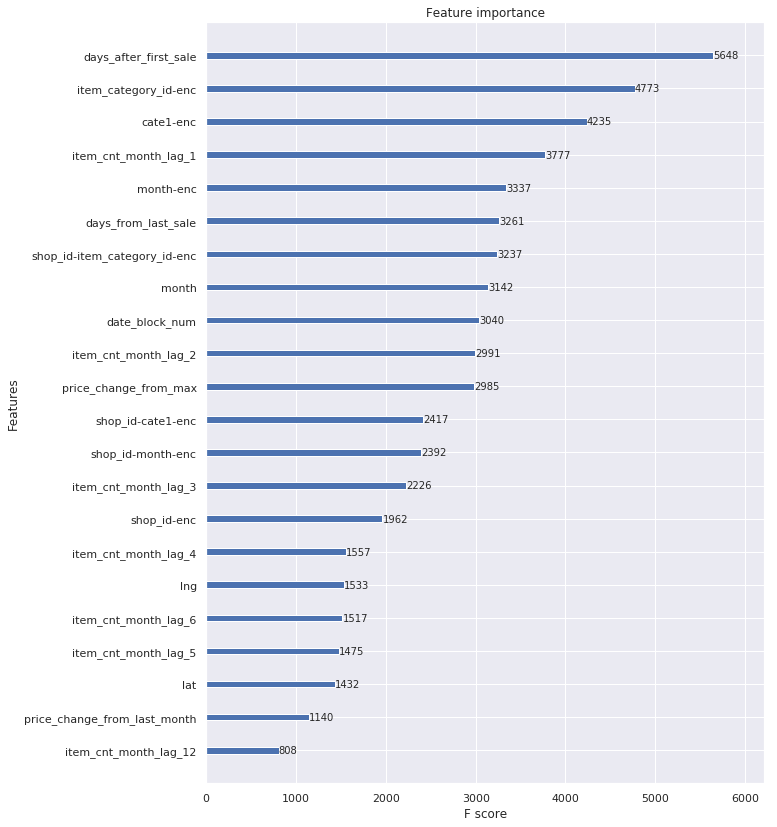

In [7]:
bst = xgb.train(xgbparams, xgbtrain,
                evals=watchlist,
                num_boost_round=5000,
                early_stopping_rounds=200,
                verbose_eval=10)

f = plt.figure(figsize=(10, 14))
xgb.plot_importance(bst, plt.gca())

In [9]:
# Best Iteration (Your result is almost guaranteed to be different than mine. But the score should be close)
best_it = 577
xgbtest = xgb.DMatrix(xy_split(xgbselect(test))[0])
xgb_meta_B = bst.predict(xgbvalidB, ntree_limit=best_it)
xgb_meta_C = bst.predict(xgbvalidC, ntree_limit=best_it)
xgb_meta_test = bst.predict(xgbtest, ntree_limit=best_it)

### 2. Support Vector Machine

In [10]:
# Select features for svm model:
svm_features = [
                TARGET,
#                 'shop_id',
#                 'item_id',
                'date_block_num',
                'lat',
                'lng',
                'item_cnt_month_lag_1',
                'item_cnt_month_lag_2',
                'item_cnt_month_lag_3',
                'item_cnt_month_lag_4',
                'item_cnt_month_lag_5',
                'item_cnt_month_lag_6',
                'item_cnt_month_lag_12',
#                 'last_price',
                'days_from_last_sale',
                'price_change_from_max',
                'price_change_from_last_month',
                'days_after_first_sale',
                'month',
#                 'days', 
#                 'item_id-enc',
                'shop_id-enc',
                'cate1-enc',
#                 'cate2-enc',
                'item_category_id-enc',
                'shop_id-cate1-enc',
                'month-enc',
                'shop_id-item_category_id-enc',
                'shop_id-month-enc',
]

In [11]:
svmfilter = lambda x: x.loc[x['date_block_num']>least_month, x.columns[x.columns.isin(svm_features)]].astype('float64')

X_partA, Y_partA = xy_split(svmfilter(partA), clip='none')
X_partB, Y_partB = xy_split(svmfilter(partB), clip='none')
X_partC, Y_partC = xy_split(svmfilter(partC), clip='none')
X_test, _ = xy_split(svmfilter(test), clip='none')

__Preprocessing our data for SVM__:
Normalization

In [12]:
from sklearn import preprocessing
from sklearn.svm import LinearSVR

# Standard normalization on the whole train set
scaler = preprocessing.StandardScaler().fit(xy_split(svmfilter(train))[0])
X_partA, X_partB, X_partC, X_test = (scaler.transform(x) for x in (X_partA, X_partB, X_partC, X_test))

Now train the model

In [16]:
svr = LinearSVR(
    loss = 'squared_epsilon_insensitive',  # For L2 loss
    epsilon = 0.1,
    random_state = 3,
    dual = False,   # As we have much more samples than features
    tol = 1e-6,
    C = 0.2,
    max_iter = 10000
)
svr.fit(X_partA, Y_partA)

LinearSVR(C=0.2, dual=False, epsilon=0.1, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=10000, random_state=3, tol=1e-06, verbose=0)

In [17]:
score(svr.predict(X_partB), Y_partB)
score(svr.predict(X_partC), Y_partC)

0.9894900867921557

0.897310934987849

In [18]:
svm_meta_B = svr.predict(X_partB)
svm_meta_C = svr.predict(X_partC)
svm_meta_test = svr.predict(X_test)

### 3. Ensembling

Strategy: weighted average:
$$ \alpha\cdot p_{xgb} + (1-\alpha)\cdot p_{svm}, $$
where $p_{xgb}$ and $p_{svm}$ are the predictions from `xgb` model and `svm` model respectively.

In [19]:
X_metaB = np.column_stack([xgb_meta_B, svm_meta_B])
X_metaC = np.column_stack([xgb_meta_C, svm_meta_C])
X_meta_test = np.column_stack([xgb_meta_test, svm_meta_test])

In [20]:
meta_predict = lambda data, alpha: np.average(data, axis=1, weights=[alpha, 1-alpha])

In [21]:
# Use a brute line search to determine alpha
for alpha in np.linspace(0, 1, 11):
    print('alpha: %f, Bscore:%f, Cscore: %f'%(
              alpha,
              score(meta_predict(X_metaB, alpha), Y_partB),
              score(meta_predict(X_metaC, alpha), Y_partC),
              )
         )

alpha: 0.000000, Bscore:0.989490, Cscore: 0.897311
alpha: 0.100000, Bscore:0.973435, Cscore: 0.881512
alpha: 0.200000, Bscore:0.958754, Cscore: 0.866586
alpha: 0.300000, Bscore:0.945416, Cscore: 0.852717
alpha: 0.400000, Bscore:0.933126, Cscore: 0.840282
alpha: 0.500000, Bscore:0.921459, Cscore: 0.829459
alpha: 0.600000, Bscore:0.911725, Cscore: 0.820430
alpha: 0.700000, Bscore:0.903764, Cscore: 0.812641
alpha: 0.800000, Bscore:0.897748, Cscore: 0.806786
alpha: 0.900000, Bscore:0.893989, Cscore: 0.803225
alpha: 1.000000, Bscore:0.892524, Cscore: 0.802171


In [22]:
# Seems like the optimal alpha is in between .9 and 1
for alpha in np.linspace(0.9, 1, 101):
    print('alpha: %3f, Bscore:%9f, Cscore: %9f'%(
              alpha,
              score(meta_predict(X_metaB, alpha), Y_partB),
              score(meta_predict(X_metaC, alpha), Y_partC),
              )
         )

alpha: 0.900000, Bscore: 0.893989, Cscore:  0.803225
alpha: 0.901000, Bscore: 0.893954, Cscore:  0.803201
alpha: 0.902000, Bscore: 0.893919, Cscore:  0.803178
alpha: 0.903000, Bscore: 0.893885, Cscore:  0.803155
alpha: 0.904000, Bscore: 0.893850, Cscore:  0.803132
alpha: 0.905000, Bscore: 0.893817, Cscore:  0.803109
alpha: 0.906000, Bscore: 0.893783, Cscore:  0.803087
alpha: 0.907000, Bscore: 0.893750, Cscore:  0.803065
alpha: 0.908000, Bscore: 0.893718, Cscore:  0.803043
alpha: 0.909000, Bscore: 0.893685, Cscore:  0.803022
alpha: 0.910000, Bscore: 0.893653, Cscore:  0.803001
alpha: 0.911000, Bscore: 0.893622, Cscore:  0.802980
alpha: 0.912000, Bscore: 0.893591, Cscore:  0.802959
alpha: 0.913000, Bscore: 0.893560, Cscore:  0.802939
alpha: 0.914000, Bscore: 0.893530, Cscore:  0.802919
alpha: 0.915000, Bscore: 0.893500, Cscore:  0.802899
alpha: 0.916000, Bscore: 0.893471, Cscore:  0.802877
alpha: 0.917000, Bscore: 0.893441, Cscore:  0.802856
alpha: 0.918000, Bscore: 0.893413, Cscore:  0.

In [23]:
# Select the best alpha
alpha = 0.982
predict = meta_predict(X_meta_test, alpha)

In [24]:
# The function `prepare_submission` will
#     1. clip input `predict` (first argument <predict>)
#     2. generate cvs file in '../submissions/<submission>.csv.gz' (second argument <submission>)
#     3. return the dataframe written to submission file (suppressed display by ending semicolon)
prepare_submission(predict, 'submission'); # public: 0.96443

### Final submission (use all data)

In [27]:
# XGBoost model
xgb_alltrain = xgb.DMatrix(*xy_split(xgbselect(train)))

bst = xgb.train(xgbparams, xgb_alltrain,
                num_boost_round=best_it)

xgb_meta_test = bst.predict(xgbtest)

In [28]:
# SVM model
X_train, Y_train = xy_split(svmfilter(train), clip='none')

X_train = scaler.transform(X_train)

svr = LinearSVR(
    loss = 'squared_epsilon_insensitive',  # For L2 loss
    epsilon = 0.1,
    random_state = 3,
    dual = False,
    tol = 1e-6,
    C = 0.5,
    max_iter = 10000
)
svr.fit(X_train, Y_train)

svm_meta_test = svr.predict(X_test) # X_test is already normalized in previous section

LinearSVR(C=0.5, dual=False, epsilon=0.1, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=10000, random_state=3, tol=1e-06, verbose=0)

In [31]:
pred = meta_predict(np.column_stack([xgb_meta_test, svm_meta_test]), alpha)

prepare_submission(pred, 'final_submission'); # 0.95730

In [32]:
# Save models
bst.save_model('../models/final_bst')
dump(svr, '../models/final_svr.pickle')